In [2]:
import Pkg; Pkg.activate("E:/Julia/JuliaEnv/OptMINLP_env")
Pkg.status()

  Activating project at `E:\Julia\JuliaEnv\OptMINLP_env`


Status `E:\Julia\JuliaENV\OptMINLP_env\Project.toml`
  [87dc4568] HiGHS v1.5.2
  [b6b21f68] Ipopt v1.4.1
  [4076af6c] JuMP v1.11.1
  [2ddba703] Juniper v0.9.1
  [cd433a01] Pavito v0.3.6


# Simultaneous Optimization for HEN Synthesis 
This model designs a heat exchanger network which operates at minimal annual cost and satisfies heating and cooling requirements. The superstructure representation consists of two stages with eight possible exchangers.

Keywords: mixed integer nonlinear programming(MINLP), chemical engineering, heat exchanger network

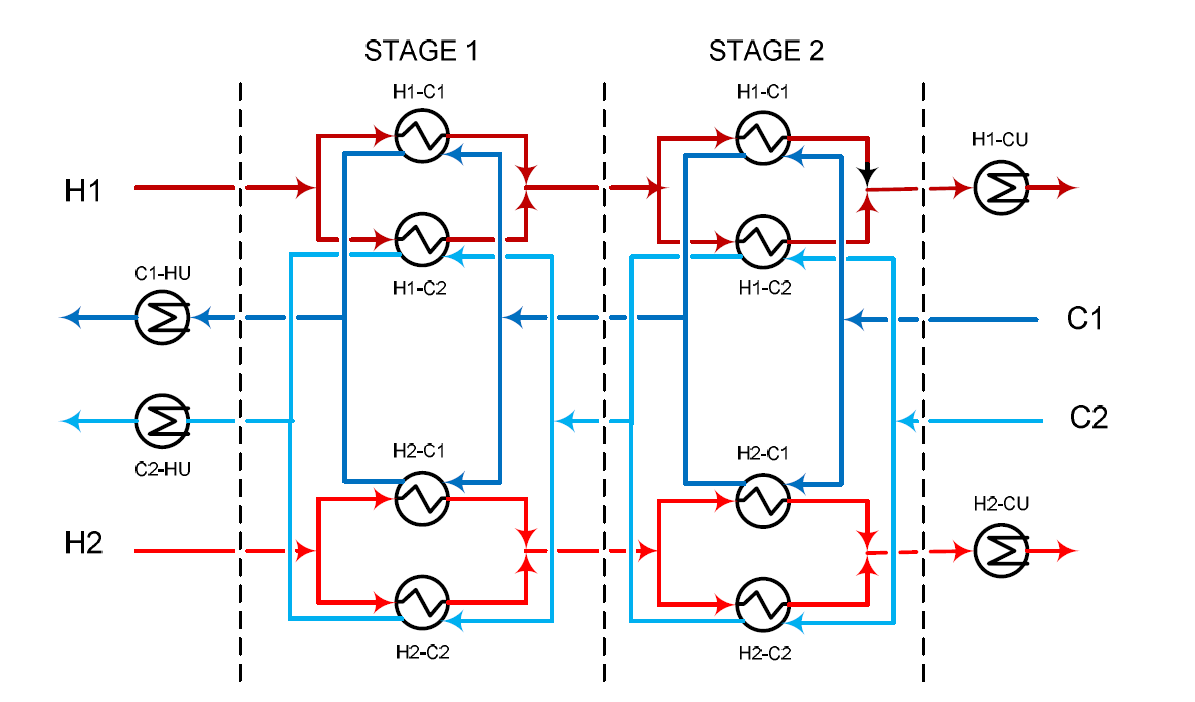

## Notes
* JuMP没有像GAMS的可以用xx1*xx100类似的方法快速表示集合，可以直接用数组表示集合
* JuMP在变量定义时可以直接规定边界和初始值
* JuMP直接定义约束不需要写声明
* 目标函数和约束非线性一定要加NL
* JuMP不用额外定义变量表示目标函数
* 大规模非凸(MI)NLP模型变量初值和变量界限很重要
* 该脚本是JuMP入门级写法，没有导入外界文件数据的部分以及函数化

## Package import

In [3]:
using JuMP, Juniper #GAMS Pavito Juniper HiGHS Gurobi Alpine
import HiGHS, Ipopt

## JuMP Model

In [4]:
nl_solver = optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)
mip_solver = optimizer_with_attributes(HiGHS.Optimizer, "output_flag"=>false)
minlp_solver = optimizer_with_attributes(Juniper.Optimizer, "nl_solver"=>nl_solver, "mip_solver"=>mip_solver)
m = Model(minlp_solver)
# m = Model(GAMS.Optimizer)
# set_optimizer_attribute(m, GAMS.ModelType(), "minlp")
# set_optimizer_attribute(m, "minlp", "dicopt")
# set_optimizer_attribute(m, "OptCR", "0.01")

set_silent(m) #Close the display of solver log
set_time_limit_sec(m, 60.0) # Set the maximum allowable time to 60 seconds
#unset_silent(m)
#unset_time_limit_sec(m)

#Sets
I = [1, 2] #hot stream
J = [1, 2] #cold stream
K = [k for k in 1:3] #temperature location
S = [s for s in 1:length(K)-1]# stage
#Parameters
Fh = Dict(1 => 10, 2 => 20) #Heat capacity flow rate
Fc = Dict(1 => 15, 2 => 13) 
Hh = Dict(1 => 1, 2 => 1) #Heat transfer coefficient
Hc = Dict(1 => 1, 2 => 1) 
Thin = Dict(1 => 650, 2 => 590) #进出温度
Thout = Dict(1 => 370, 2 => 370) 
Tcin = Dict(1 => 410, 2 => 350) 
Tcout = Dict(1 => 650, 2 => 500) 
Ech = Dict(I[i] => Fh[i]*(Thin[i] - Thout[i]) for i in I) #流股总换热量 
Ecc = Dict(J[j] => Fc[j]*(Tcout[j] - Tcin[j]) for j in J)
Gamma = Dict((I[i], J[j]) => max(0, Tcin[j] - Thin[i], Tcin[j] - Thout[i], 
                                  Tcout[j] - Thin[i], Tcout[j] - Thout[i]) for i in I, j in J) #最大传热温差
#费用和公用工程相关参数
Hucost = 80;  Hucoeff = 150; Thuin = 680; Thuout = 680; Hhu = 5;
Cucost = 15;  Cucoeff = 150; Tcuin = 300; Tcuout = 320; Hcu = 1;
Unitc = 5500; Acoeff = 150;
Aexp  = 1;    Tmapp  = 10;

In [5]:
#variable
@variables(m, begin # macro for multiple variables 
    ## binary variables
    z[I, J, K], Bin
    zcu[I], Bin
    zhu[J], Bin
    ## positive variables, bounds and start values
    qc[I] ≥ 0
    qh[J] ≥ 0
    Thin[i] ≥ th[i = 1:length(I), k = 1:length(K)] ≥ Thout[i], (start = Thin[i]) #h进入第k级的温度, The starting value should be in parentheses
    Tcout[j] ≥ tc[j = 1:length(J), k = 1:length(K)] ≥ Tcin[j], (start = Tcin[j]) #c离开第k级的温度
    q[I, J, K] ≥ 0 #ij在第k级交换的热量 ,q是定义在1到k的
    dt[i = 1:length(I) , j = 1:length(J), k = 1:length(K)] ≥ Tmapp, (start = Thin[i] - Tcin[j]) #温差
    dtcu[i = 1:length(I)] ≥ Tmapp, (start = Thin[i] - Tcuout)
    dthu[j = 1:length(J)] ≥ Tmapp, (start = Thuout - Tcin[j])
end)

for i = 1:length(I), j = 1:length(J), k = 1:length(S)
    set_start_value(q[i, j, k], min(Ech[i], Ecc[j])) 
end

#constraint
@constraints(m, begin
    eq1_ohbi[i in I], (Thin[i]-Thout[i])*Fh[i] == sum(q[i, j, k] for j in J, k in S) + qc[i] 
    eq2_ohbj[j in J], (Tcout[j]-Tcin[j])*Fc[j] == sum(q[i, j, k] for i in I, k in S) + qh[j] #单个流股整体热量平衡
    [i in I, k in S], Fh[i]*(th[i, k] - th[i, k+1]) == sum(q[i, :, k]) 
    [j in J, k in S], Fc[j]*(tc[j, k] - tc[j, k+1]) == sum(q[:, j, k]) #单个级热量平衡 
    [i in I], Fh[i]*(th[i, last(K)]-Thout[i]) == qc[i]     
    [j in J], Fc[j]*(Tcout[j]-tc[j, first(K)]) == qh[j] #跟公用工程交换的热量 
    [i in I], Thin[i] == th[i, first(K)]
    [j in J], Tcin[j] == tc[j, last(K)] #某段级温度赋值  
    [i in I, k in S], th[i, k] ≥ th[i, k+1] #温度单调性
    [j in J, k in S], tc[j, k] ≥ tc[j, k+1]
    [i in I], th[i, last(K)] ≥ Thout[i] 
    [j in J], Tcout[j] ≥ tc[j, first(K)]
    [i in I, j in J, k in S], q[i, j, k] - min(Ech[i], Ecc[j])*z[i, j, k] ≤ 0
    [i in I], qc[i] - Ech[i]*zcu[i] ≤ 0 #换热量限制big_M
    [j in J], qh[j] - Ecc[j]*zhu[j] ≤ 0
    [i in I, j in J, k in S], dt[i, j, k] ≤ th[i, k] - tc[j, k] + Gamma[i, j]*(1 - z[i, j, k]) #温差限制big_M
    [i in I, j in J, k in S], dt[i, j, k+1] ≤ th[i, k+1] - tc[j, k+1] + Gamma[i, j]*(1 - z[i, j, k])
    [j in J], dthu[j] ≤ Thuout - tc[j, first(K)]
    [i in I], dtcu[i] ≤ th[i, last(K)] - Tcuout
end)

#objective
@NLobjective(m, Min, 
             Unitc*(sum(z[i,j,k] for i in I, j in J, k in S)                
            +  sum(zcu[i] for i in I) + sum(zhu[j] for j in J)) #换热器固定项投资费

            +  Acoeff*sum((q[i,j,k]*((1/Hh[i]) + (1/Hc[j])) #换热器变化项投资费
            /  (((dt[i,j,k]*dt[i,j,k+1]*(dt[i,j,k] + dt[i,j,k+1])/2
            +  1e-6)^0.33333) + 1e-6) + 1e-6)^Aexp for i in I, j in J, k in S)

            +  Hucoeff*(sum((qh[j]*((1/Hc[j]) + 1/Hhu))
            /  (((Thuin - Tcout[j])*dthu[j]*((Thuin - Tcout[j] + dthu[j])/2)
            +  1e-6)^0.33333) + 1e-6 for j in J)^Aexp)

            +  Cucoeff*sum((qc[i]*((1/Hh[i]) + (1/Hcu))
            /  (((Thout[i]-Tcuin)*dtcu[i]*(Thout[i] - Tcuin + dtcu[i])/2
            +  1e-6)^0.33333) + 1e-6)^Aexp for i in I)                     

            +  sum(qh[j]*Hucost for j in J) + sum(qc[i]*Cucost for i in I) #公用工程费
            )

optimize!(m);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



┌ Warning: Cycle detected
└ @ Juniper E:\Julia\JuliaPKG\packages\Juniper\0Z1vO\src\fpump.jl:372


┌ Warning: Only almost solved
└ @ Juniper E:\Julia\JuliaPKG\packages\Juniper\0Z1vO\src\BnBTree.jl:116


┌ Warning: Only almost solved
└ @ Juniper E:\Julia\JuliaPKG\packages\Juniper\0Z1vO\src\BnBTree.jl:116


┌ Warning: Only almost solved
└ @ Juniper E:\Julia\JuliaPKG\packages\Juniper\0Z1vO\src\BnBTree.jl:116


Solution Aanlysis

In [6]:
#@show termination_status(m)
#@show primal_status(m)
#@show dual_status(m)
#@show objective_value(m)
#@show start_value.(th)
#solution_summary(m, verbose=false)
if termination_status(m) == OPTIMAL
    println("Solution is optimal.")
elseif termination_status(m) == LOCALLY_SOLVED
    println("Solution is local optimal.")
else
    error("The model was not solved correctly.")
end
println("Total annual cost = $(round(objective_value(m); digits=3)) \$/year") 
println("The total number of heat exchanger is $(sum(round.(value.(z))) + sum(round.(value.(zhu))) + sum(round.(value.(zcu))))")
println("The positions of heat exchangers are as follows:")
for i in I, j in J, k in S
    if round(value(z[i,j,k])) > 0
        println("hot stream $i with cold stream $j at stage $k")
    end
end 

for j in J
    if round(value(zhu[j])) > 0
        println("hot utility with cold stream $j")
    end
end 

for i in I
    if round(value(zcu[i])) > 0
        println("cold utility with hot stream $i")
    end
end 

Solution is local optimal.


Total annual cost = 154997.33 $/year


The total number of heat exchanger is 6.0
The positions of heat exchangers are as follows:
hot stream 1 with cold stream 1 at stage 1
hot stream 1 with cold stream 2 at stage 2
hot stream 2 with cold stream 1 at stage 2
hot utility with cold stream 1
cold utility with hot stream 1
cold utility with hot stream 2


## References
Yee, T F, and Grossmann, I E, Simultaneous Optimization of Models for Heat Integration - Heat Exchanger Network Synthesis. Computers and
Chemical Engineering 14, 10 (1990), 1151-1184 https://www.sciencedirect.com/science/article/abs/pii/009813549080001R
